In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [2]:
images_gray = []
images_rgb = []

folder_path = 'cap-inspection-images/project_1_liner_inspection/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    if file_path.endswith(('.bmp')):
        img = cv2.imread(file_path)
        images_rgb.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        images_gray.append(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
print('Loaded '+ str(len(images_gray))+ ' images!')

Loaded 16 images!


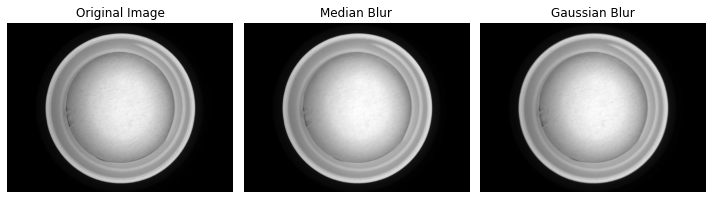

In [3]:
median_blur = []
gaussian_blur = []

for index, img_gray in enumerate(images_gray):
    
    median_blur.append(cv2.medianBlur(img_gray, 5))  

    gaussian_blur.append(cv2.GaussianBlur(img_gray, (5, 5), 0))  

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(images_gray[0], cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Median Blur')
plt.imshow(median_blur[0], cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Gaussian Blur')
plt.imshow(gaussian_blur[0], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

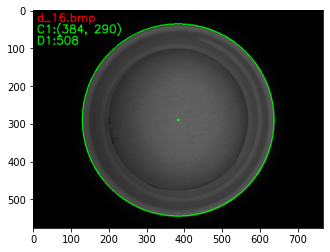

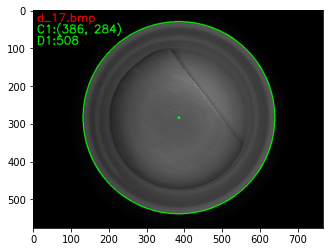

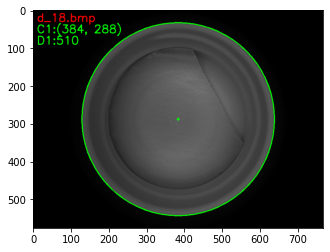

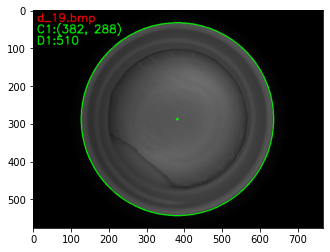

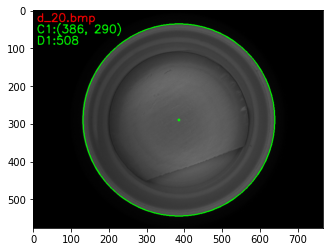

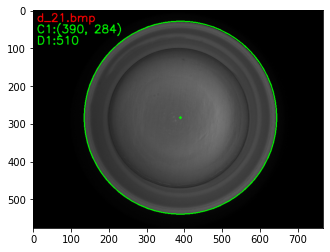

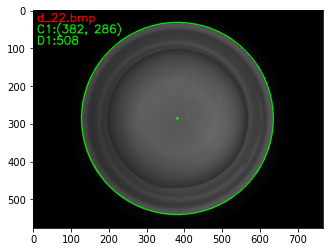

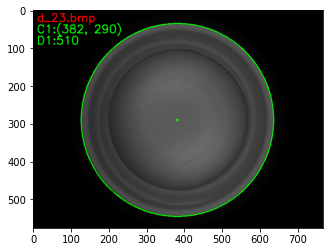

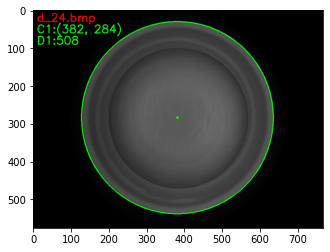

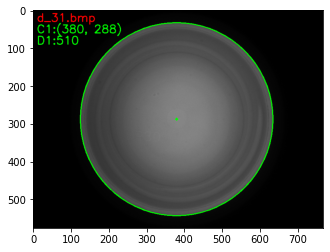

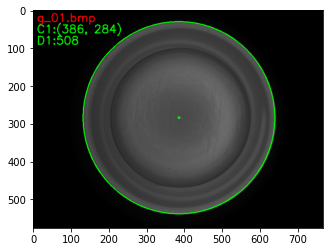

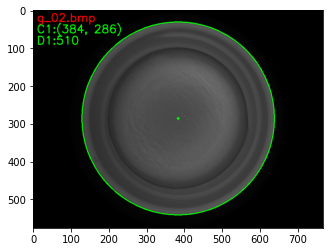

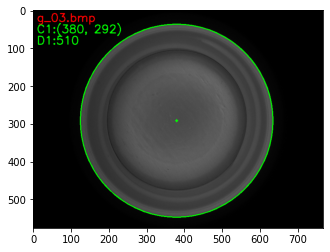

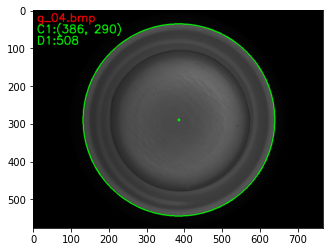

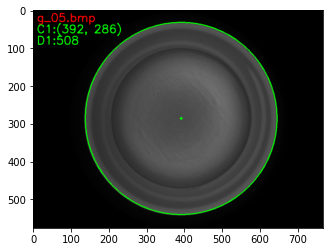

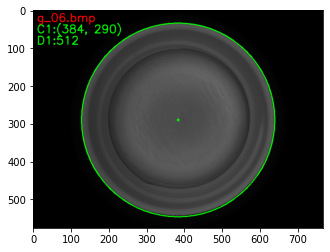

In [4]:
mouth_center = []
image_mouth = []

for index, med_img in enumerate(median_blur):
    image_mouth.append(np.copy(images_rgb[index]))
    mouth_circle = cv2.HoughCircles(med_img, cv2.HOUGH_GRADIENT, dp=1, minDist=25,
                               param1=45,param2=60,minRadius=250,maxRadius=260)

    if mouth_circle is not None:
        mouth_circle = np.uint16(np.around(mouth_circle))
        for i in mouth_circle[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            mouth_center.append((center,radius))
            cv2.circle(image_mouth[index], center, radius, (0, 255, 0), 2)
            cv2.circle(image_mouth[index], center, 2, (0, 255, 0), 3)
            
            cv2.putText(image_mouth[index], file_names[index], (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
            captext = f"C1:{mouth_center[index][0][0],mouth_center[index][0][1]}"
            cv2.putText(image_mouth[index], captext, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            diametertext = f"D1:{mouth_center[index][1]*2}"
            cv2.putText(image_mouth[index], diametertext, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
#             print('center of the cap: ',center)
#             print('diameter of the cap mouth: ',radius*2)
            plt.imshow(image_mouth[index])
            plt.show()
    else:
        print("No mouth circle detected!")    
        

In [5]:
liner_threshold = 80
masked_mouth = []
mean_brightness = []
liner_missing = []

for index, med_img in enumerate(median_blur):
    mask = np.zeros_like(med_img)
    cv2.circle(mask, mouth_center[index][0], mouth_center[index][1], 255, -1)
    masked_mouth.append(cv2.bitwise_and(med_img,mask))
    mean_brightness.append(np.around(np.mean(masked_mouth[index][mask == 255]),2))
    if mean_brightness[index] >= liner_threshold:
        liner_missing.append('Liner missing')
    else:
        liner_missing.append('Has liner')
        
#     cv2.putText(masked_mouth[index], file_names[index], (10, 30), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
#     mean_brightnesstext = f"mean_brightness:{mean_brightness[index]}"
#     cv2.putText(masked_mouth[index], mean_brightnesstext, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
#     cv2.putText(masked_mouth[index], liner_missing[index], (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)        
#     plt.imshow(masked_mouth[index], cmap='gray')
#     plt.show()
#     print("mean lightness:", mean_brightness)

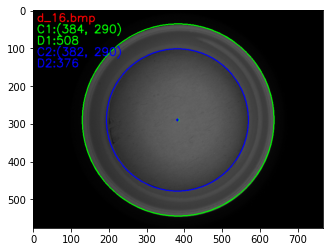

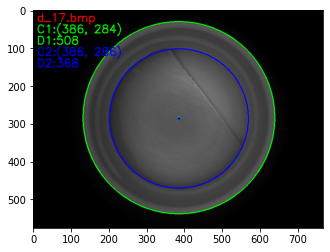

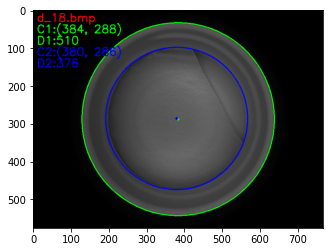

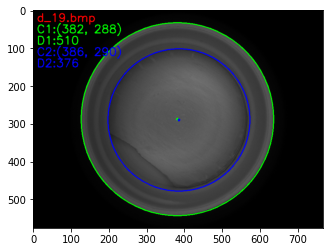

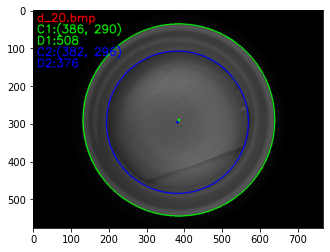

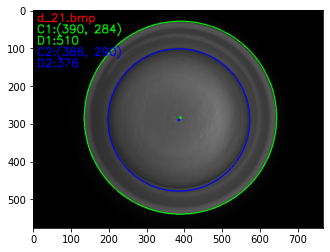

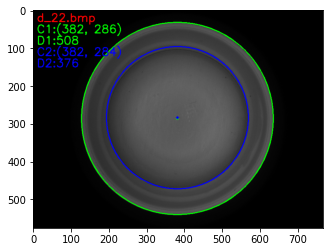

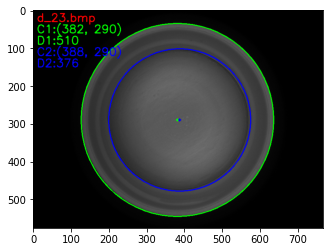

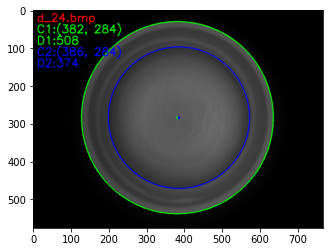

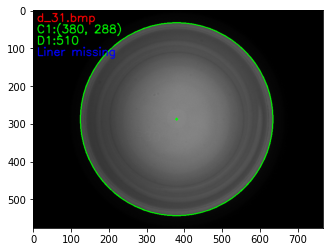

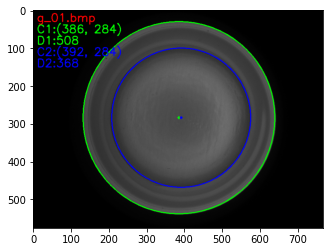

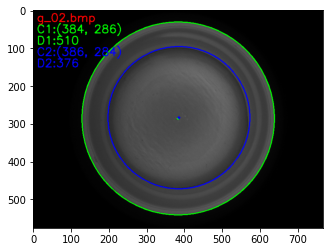

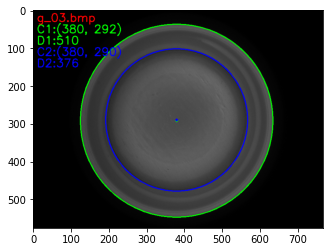

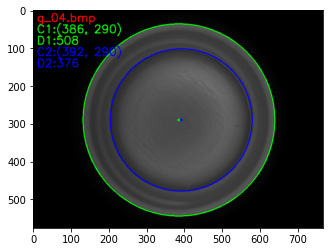

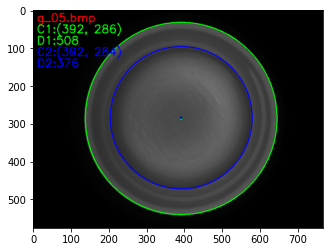

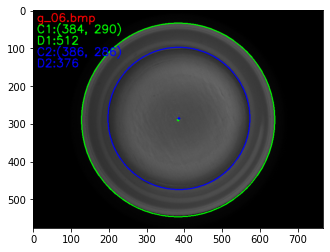

In [6]:
image_liner = []
liner_center = []

for index, mask_m in enumerate(masked_mouth):
    image_liner.append(np.copy(image_mouth[index]))
    
    if liner_missing[index] == 'Liner missing':
        liner_center.append(((0,0),0))
        cv2.putText(image_liner[index], liner_missing[index], (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2) 
        plt.imshow(image_liner[index])
        plt.show()
    else:
        liner_circle = cv2.HoughCircles(mask_m, cv2.HOUGH_GRADIENT,dp=3, minDist=300,
                                        param1=80,param2=70,minRadius=180,maxRadius=190)

        if liner_circle is not None:
            liner_circle = np.uint16(np.around(liner_circle))
            for i in liner_circle[0, :]:
                center = (i[0], i[1])
                radius = i[2]
                liner_center.append((center,radius))
    
        
            cv2.circle(image_liner[index], center, radius, (0, 0, 255), 2)
            cv2.circle(image_liner[index], center, 2, (0, 0, 255), 3)

            linertext = f"C2:{liner_center[index][0][0],liner_center[index][0][1]}"
            cv2.putText(image_liner[index], linertext, (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            diametertext = f"D2:{liner_center[index][1]*2}"
            cv2.putText(image_liner[index], diametertext, (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            plt.imshow(image_liner[index])
            plt.show()
        else:
            print("No liner circle detected!")  

In [7]:
mask_liner_shrink = 10
masked_liner = []

for index, mask_m in enumerate(masked_mouth):
    mask_lin = np.zeros_like(mask_m)
    if liner_missing[index] == 'Liner missing':
        masked_liner.append(mask_lin)
    else:
        mask_lin = np.zeros_like(mask_m)
        cv2.circle(mask_lin, liner_center[index][0], liner_center[index][1]-mask_liner_shrink, 255, -1)
        masked_liner.append(cv2.bitwise_and(mask_m,mask_lin))
#     plt.imshow(masked_liner[index], cmap='gray')
#     plt.show()

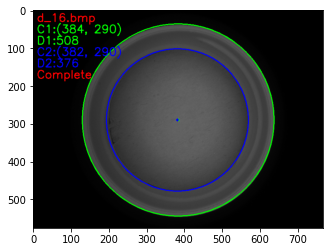

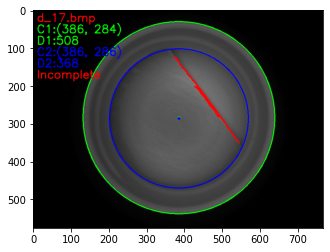

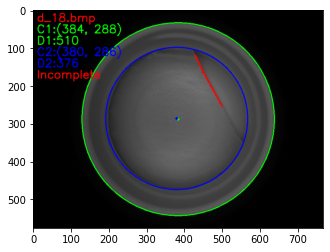

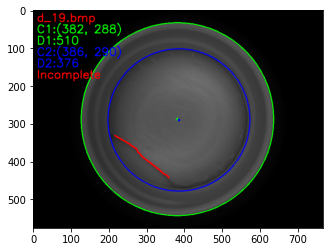

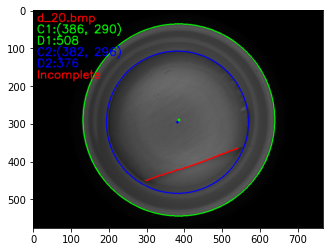

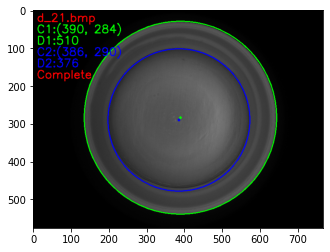

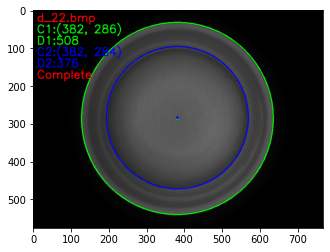

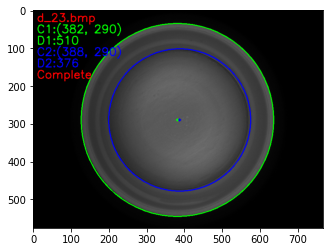

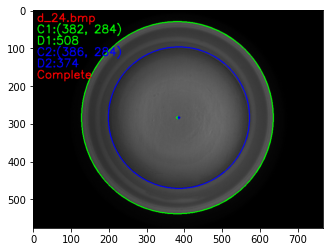

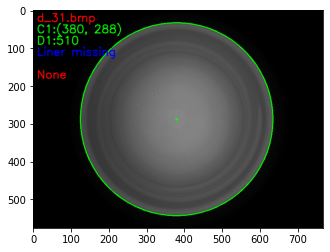

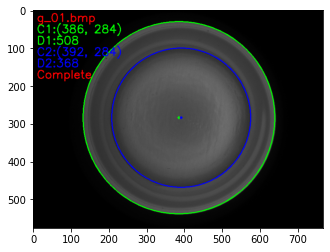

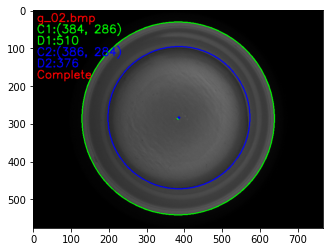

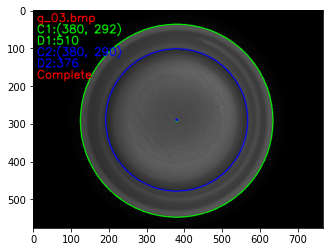

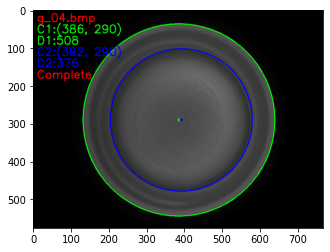

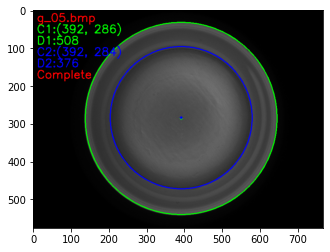

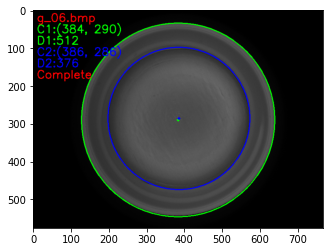

In [8]:
defect_canny = []
defect = []
for index, mask_lin in enumerate(masked_liner):
    defect_canny.append(np.copy(image_liner[index]))
    edges = cv2.Canny(mask_lin, threshold1=20, threshold2=60)
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if contours is not None:
        filtered_contours = []
        for contour in contours:
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            if len(approx) == 2: 
                filtered_contours.append(contour)
            cv2.drawContours(defect_canny[index], filtered_contours, -1, (255, 0, 0), 2)
        if len(filtered_contours) ==0:
            if liner_missing[index] == 'Liner missing':
                defect.append('None')
            else:
                defect.append('Complete')
        else:
            defect.append('Incomplete')
    else:
        print("No contour detected!") 
        
    defecttext = f"{defect[index]}"
    cv2.putText(defect_canny[index], defecttext, (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)    
    plt.imshow(defect_canny[index])
    plt.show()

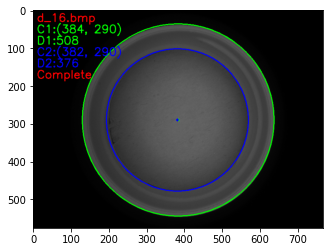

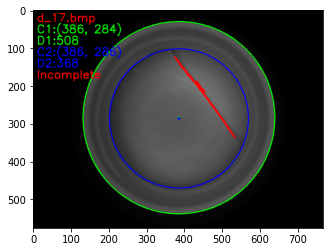

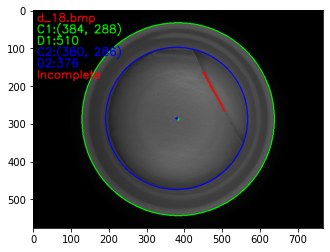

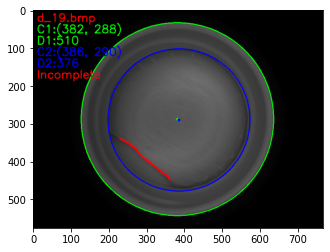

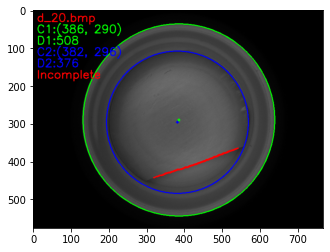

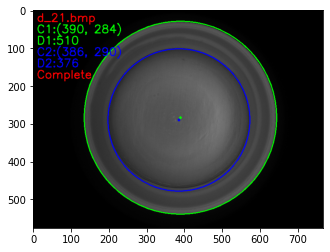

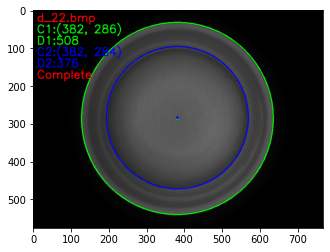

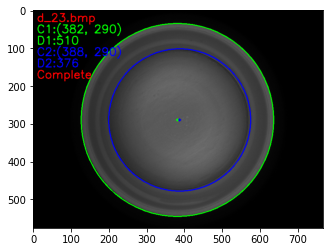

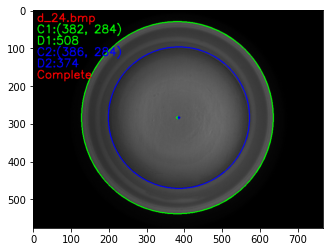

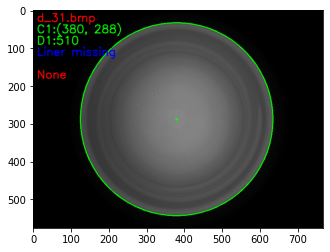

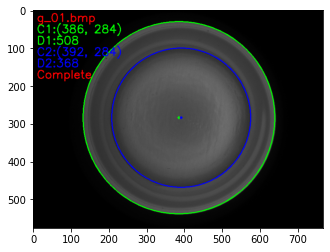

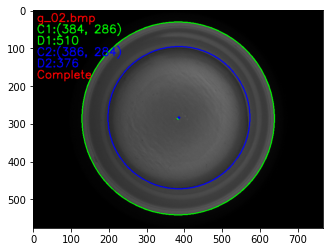

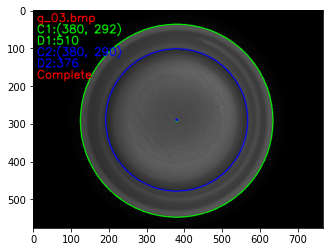

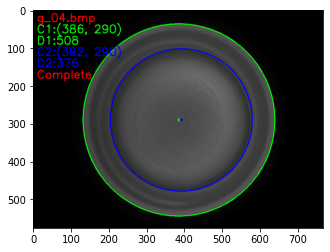

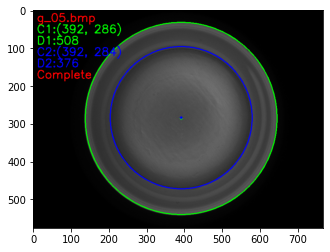

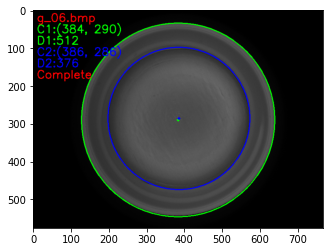

In [9]:
defect_sobel = []
defect = []
min_contour_length_threshold = 100

for index, mask_lin in enumerate(masked_liner):
    defect_sobel.append(np.copy(image_liner[index]))
    
    clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(mask_lin)
    
    grad_x = cv2.Sobel(enhanced_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(enhanced_image, cv2.CV_64F, 0, 1, ksize=3)

    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
#     plt.imshow(gradient_magnitude, cmap='gray')
#     plt.show()
    threshold_value = 120
    _, binary_image = cv2.threshold(gradient_magnitude, threshold_value, 255, cv2.THRESH_BINARY)
    binary_image = np.uint8(binary_image)
    kernel = np.ones((15,15),np.uint8)
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if contours is not None:
        filtered_contours = []
        for contour in contours:
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            contour_length = cv2.arcLength(contour, True)
            if contour_length > min_contour_length_threshold:
                if len(approx) == 2: 
                    filtered_contours.append(contour)
            cv2.drawContours(defect_sobel[index], filtered_contours, -1, (255, 0, 0), 2)
        if len(filtered_contours) ==0:
            if liner_missing[index] == 'Liner missing':
                defect.append('None')
            else:
                defect.append('Complete')
        else:
            defect.append('Incomplete')
    else:
        print("No contour detected!") 
    
    defecttext = f"{defect[index]}"
    cv2.putText(defect_sobel[index], defecttext, (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    plt.imshow(defect_sobel[index])
    plt.show()

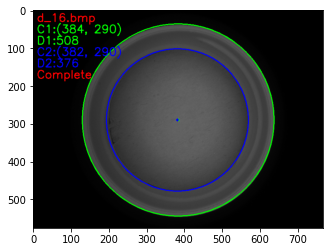

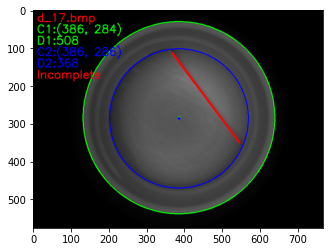

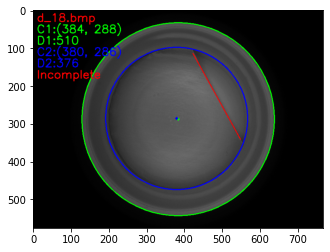

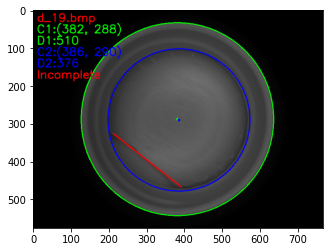

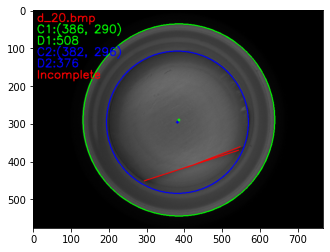

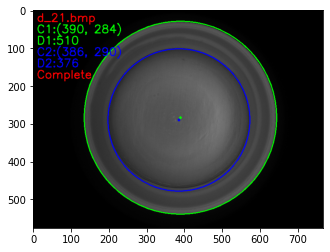

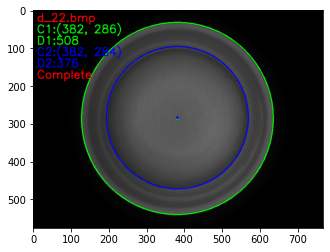

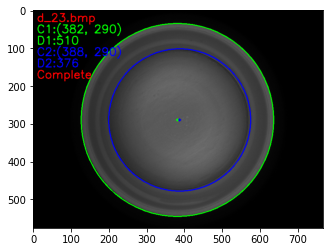

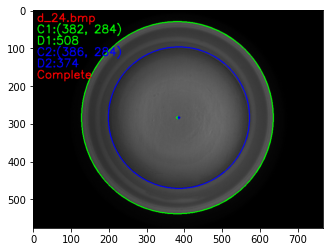

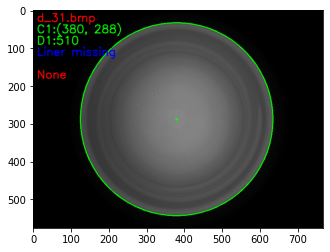

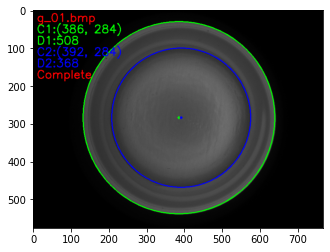

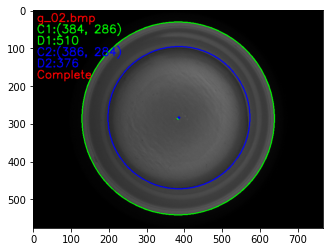

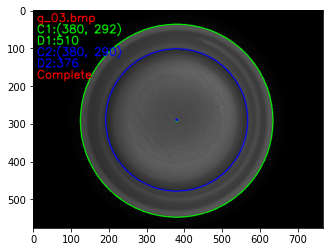

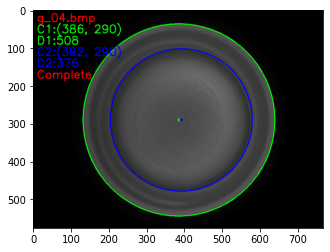

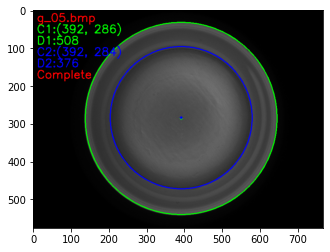

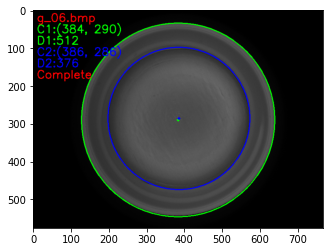

In [10]:
defect_line = []
defect = []

for index, mask_lin in enumerate(masked_liner):
    defect_line.append(np.copy(image_liner[index]))
    edges = cv2.Canny(mask_lin, 20, 40, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=20, maxLineGap=100)
    if lines is not None:
        defect.append('Incomplete')
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(defect_line[index], (x1, y1), (x2, y2), (255, 0, 0), 2)
    else:
        if liner_missing[index] == 'Liner missing':
            defect.append('None')
        else:
            defect.append('Complete')
        
    defecttext = f"{defect[index]}"
    cv2.putText(defect_line[index], defecttext, (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)    
    plt.imshow(defect_line[index])
    plt.show()